# Transfer Entropy 

Saleh Rezaeiravesh, saleh.rezaeiravesh@manchester.ac.uk
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../core/')
from te import bi_te
from pseudoTE import pTE
import synData

## Transfer Entropy (TE)

For time series, [Schreiber 2000](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.85.461) defines the transfer of entropy from $x$ to $y$ as, 

$$
TE_{x\to y} = \sum_{y_i,y_i^n,x_i^m} p(y_i,y_i^n,x_i^m)\log \frac{p(y_i|y_i^n,x_i^m)}{p(y_i|y_i^n)}
$$

where, delay embedded vectors are:

* $y_i^n = (y_{i-1},y_{i-2},\cdots,y_{i-n})$
* $x_i^m = (x_{i-1},x_{i-2},\cdots,x_{i-m})$

with $m,\, n\leq 1$



* TE is a measure of **statistical causality**. 
* TE is **directional** and **assymetric**, i.e. $TE_{x\to y}\neq TE_{y\to x}$. Therefore, we can define the **Net Information Flow** between $x$ and $y$ as, 

$$
\hat{TE}_{x\to y}  = TE_{x\to y} - TE_{y\to x}
$$


## Methods for estimating TE

### KDE method
The above equation can be written in terms of four Shannon entropies:

$$
TE_{X\to Y} = H(y_i,y_i^n) - H(y_i^n)- (H(y_i,y_i^n,x_i^m)- H(y_i^n,x_i^m))
$$

Each of the Shannon entropies can be estimated by the KDE method.

### KSG method (based on KL/KNN method)
Although, one can estimate the Shannon entropies in the above formula can be estimated by the KSG (KL/KNN) method, but this can lead to erroronous estimates for the TE, as formerly shown by [Kraskov-Stogbauer-Grassberger (KSG), 2004](https://arxiv.org/pdf/cond-mat/0305641) for the mutual information. 

As shown in [Hlavackova et al., 2007](https://www.sciencedirect.com/science/article/abs/pii/S0370157307000403), the original definition of the TE by Schreiber, can be expressed as a **cnditional mutual information**:

$$
\begin{eqnarray*}
TE_{x\to y} &=& \sum_{y_i,y_i^n,x_i^m} p(y_i,y_i^n,x_i^m)\log \frac{p(y_i,y_i^n,x_i^m)}{p(y_i|y_i^n)p(y_i^n,x_i^m)} \\
&=&
\sum p(y_i,y_i^n,x_i^m)\log p(y_i,x_i^m|y_i^n) - \sum p(y_i,y_i^n) \log p(y_i|y_i^n)
-\sum p(y_i^n,x_i^m) \log p(x_i^m|y_i^n) \\
&:=&
I(y_i,x_i^m|y_i^n)
\end{eqnarray*}
$$


To estimate the above conditional MI, [Witter and Houghton, 2024](https://arxiv.org/pdf/2403.00556) proposed two KL-KNN based estimators, similar to the KSG estimator for MI:

$$
I(X,Y|Z) \approx \psi(k)+\langle \psi(k_Z+1) - \psi(k_{XZ}+1) - \psi(k_{YZ}+1) \rangle
$$

$$
I(X,Y|Z) \approx \psi(k)-\frac{2}{k}+\langle \psi(k_Z) - \psi(k_{XZ}) - \psi(k_{YZ})-\frac{1}{k_{XZ}}-\frac{1}{k_{YZ}} \rangle
$$

In our computations, we use the first estimator. 

**Note:** For all computations, we assume $m=n$=`lag`. 

## Validation of TE estimators for VAR data with Gaussian noise

**For Gaussian variables, transfer entropy is equivalent to Granger Causality**, see [Barnett et al. 2009](https://arxiv.org/pdf/0910.4514)

* There is a formula in [Barnett et al. 2009](https://arxiv.org/pdf/0910.4514) for multivariate Gaussian RVs
* A similar formula along with its derivation is given in the appendix of [Selini & Masoller 2021](https://www.nature.com/articles/s41598-021-87818-3) for multivariate Gaussian time series. 

In the output of the following formula is called **pseudo TE (pTE)** that can be an approximatetion of TE, and it is exact for multivariate Gaussian samples. Clearly the linear algebra of the concatanted long time series can be intractable. In their implementation on [GitHub](https://github.com/riccardosilini/pTE), they have mentioned the size of the time series samples should be $<500$. 


Synthesize samples from a VAR(p) where $p\leq 3$:

In [2]:
xt_, _, _ = synData.varSampGen(n=5000,order=3)

We can choose to normalize the data: $\bar{x}=(x-mean(x))/std(x)$. The TE-KDE and pTE are expected to remain invarient against normalization, but the TE-KSG will be affected. Becasue, it relies on the KNN method and actual distances between the samples. It is recommended to normalize the samples using the same mean and sdev (not asociated to each variable).

5.684341886080802e-18 1.0
0.13123995789137008 1.1471061386395824


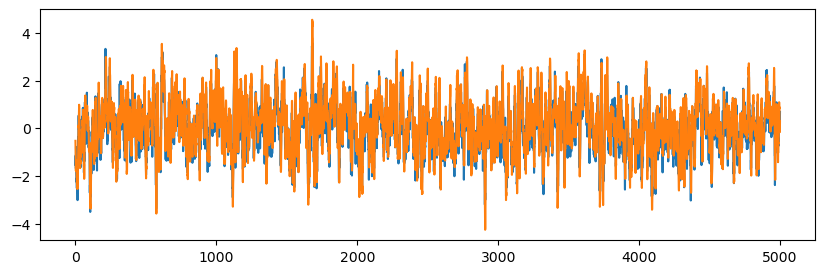

In [8]:
normalize = True

#normalization of time series data
if normalize:
   xt = np.zeros_like(xt_)
   xt[:,0]=(xt_[:,0]-np.mean(xt_[:,0]))/np.std(xt_[:,0])
   xt[:,1]=(xt_[:,1]-np.mean(xt_[:,0]))/np.std(xt_[:,0])
else:
   xt=xt_  

print(np.mean(xt[:,0]) , np.std(xt[:,0]))
print(np.mean(xt[:,1]) , np.std(xt[:,1]))

plt.figure(figsize=(10,3))
plt.plot(np.arange(xt.shape[0]),xt[:,0])
plt.plot(np.arange(xt.shape[0]),xt[:,1])
plt.show()

Compute pseudo TE at different lags, using the implementation of [Selini & Masoller 2021](https://www.nature.com/articles/s41598-021-87818-3): 

In [4]:
lagList=[1,2,3,5,7,9,11,15,20]   #lags at which TE will be estimated

pte_xy=[]
pte_yx=[]

for lag in lagList:
    pte_, ptesurr_ = pTE(xt.T, tau=lag, dimEmb=1, surr=None, Nsurr=19)
    pte_xy.append(pte_[0,1])
    pte_yx.append(pte_[1,0])
pte_xy = np.array(pte_xy)    
pte_yx = np.array(pte_yx)    

Estimate TE at the same lags using the KDE method:

In [5]:
te_kde_xy=[]
te_kde_yx=[]

for lag in lagList:   
    te1_ = bi_te(xt[:,0], xt[:,1], lag).kde()
    te_kde_xy.append(te1_)
    
    te2_ = bi_te(xt[:,1], xt[:,0], lag).kde()
    te_kde_yx.append(te2_)
te_kde_xy = np.array(te_kde_xy)    
te_kde_yx = np.array(te_kde_yx)        

Estimate TE at the same lags using the KSG method; note that the estimated TE can be sensitivie to $k$ (in the KNN method). 

In [6]:
te_ksg_xy=[]
te_ksg_yx=[]

for lag in lagList:
    te1_ = bi_te(xt[:,0], xt[:,1], lag).ksg(k=30)
    te_ksg_xy.append(te1_)
    
    te2_ = bi_te(xt[:,1], xt[:,0], lag).ksg(k=30)
    te_ksg_yx.append(te2_)
te_ksg_xy = np.array(te_ksg_xy)    
te_ksg_yx = np.array(te_ksg_yx)    

Plot KDE and KSG TEs along with the pseudo TEs at different lags:

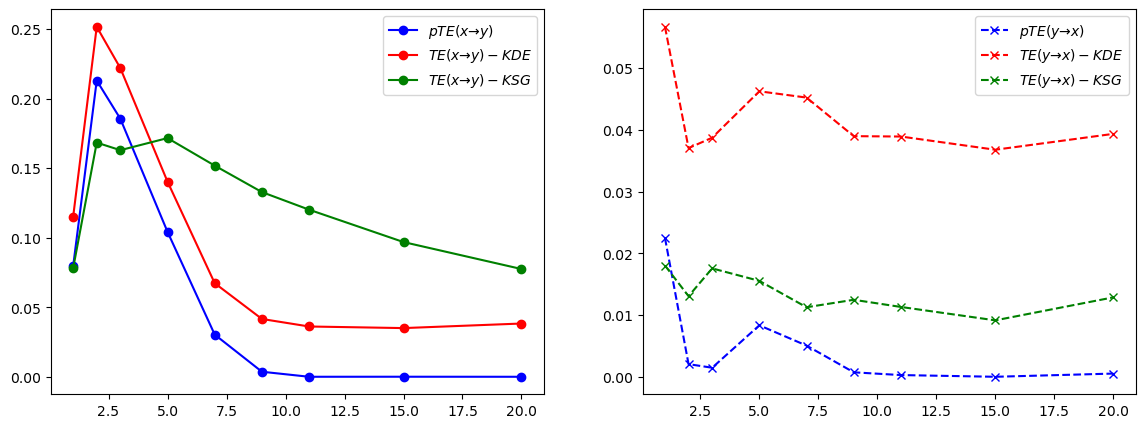

In [7]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(lagList,pte_xy,'-ob',label=r'$pTE(x\to y)$')    
plt.plot(lagList,te_kde_xy,'-or',label=r'$TE(x\to y) - KDE$')    
plt.plot(lagList,te_ksg_xy,'-og',label=r'$TE(x\to y) - KSG$')    
plt.legend(loc='best')
plt.subplot(122)
plt.plot(lagList,pte_yx,'--xb',label=r'$pTE(y\to x)$')    
plt.plot(lagList,te_kde_yx,'--xr',label=r'$TE(y\to x) - KDE$')    
plt.plot(lagList,te_ksg_yx,'--xg',label=r'$TE(y\to x) - KSG$')    

plt.legend(loc='best')
plt.show()

**Conclusions:**
* The trend of TE-KDE against lag is similar to that of the pseudo TE, but the values are different. This can be becasue of the bias in the TE-KDE estimator (four entropies). By increasing the number of samples of the time series, the difference between TE-KDE and pTE is reduced. 
* **NOTE**: The implementation of the TE-KSG is till being verified. 